In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# Load the data
df = pd.read_csv("/workspaces/Final-Project/diabetes.csv")

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
stat_summary = df.describe()
stat_summary

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
columns_with_zeroes = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[columns_with_zeroes] = df[columns_with_zeroes].replace(0, np.nan)

nan_counts_corrected = df.isna().sum()

nan_counts_corrected

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [6]:
# Function to calculate IQR and identify outliers
def calculate_iqr_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = dataframe[
        (dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)
    ]
    return outliers.index, lower_bound, upper_bound


# Identify outliers for each specified column
outlier_indices = {}
bounds = {}

for column in columns_with_zeroes:
    indices, lower, upper = calculate_iqr_outliers(df, column)
    outlier_indices[column] = indices
    bounds[column] = (lower, upper)

# Summary of outliers and bounds for each column
outlier_summary = {column: len(indices) for column, indices in outlier_indices.items()}
bounds_summary = bounds

outlier_summary, bounds_summary

({'Glucose': 0,
  'BloodPressure': 14,
  'SkinThickness': 3,
  'Insulin': 24,
  'BMI': 8},
 {'Glucose': (36.0, 204.0),
  'BloodPressure': (40.0, 104.0),
  'SkinThickness': (1.0, 57.0),
  'Insulin': (-94.375, 360.625),
  'BMI': (13.849999999999998, 50.25)})

In [7]:
# Impute missing values with the median of each column
for column in columns_with_zeroes:
    df[column].fillna(df[column].median(), inplace=True)

# After imputation, check the summary statistics again to confirm changes
df_description_after_imputation = df.describe()

df_description_after_imputation

/tmp/ipykernel_23885/979708951.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].median(), inplace=True)
/tmp/ipykernel_23885/979708951.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
# Capping function to handle outliers
## Replaces outliers
def cap_outliers(dataframe, column, lower_bound, upper_bound):
    dataframe[column] = np.where(
        dataframe[column] < lower_bound, lower_bound, dataframe[column]
    )
    dataframe[column] = np.where(
        dataframe[column] > upper_bound, upper_bound, dataframe[column]
    )


# Apply capping to each specified column based on previously calculated bounds
for column, (lower_bound, upper_bound) in bounds.items():
    cap_outliers(df, column, lower_bound, upper_bound)

# Check the summary statistics again to confirm changes
df_description_after_outlier_handling = df.describe()

df_description_after_outlier_handling

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.358073,29.041667,136.029948,32.393359,0.471876,33.240885,0.348958
std,3.369578,30.438286,11.697097,8.438802,65.560632,6.667471,0.331329,11.760232,0.476951
min,0.000000,44.000000,40.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,104.000000,57.000000,360.625000,50.250000,2.420000,81.000000,1.000000


In [9]:
# Count nulls for each column
null_counts = df.isnull().sum()

print("Null counts for each column:")
print(null_counts)

Null counts for each column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [10]:
from sklearn.preprocessing import StandardScaler

# Separating the features from the target variable
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame for easier manipulation in the next steps
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Display the first few rows of the standardized features
X_scaled_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.866045,-0.030632,0.706524,-0.168350,0.181092,0.468492,1.425995
1,-0.844885,-1.205066,-0.543914,-0.004941,-0.168350,-0.869465,-0.365061,-0.190672
2,1.233880,2.016662,-0.715008,-0.004941,-0.168350,-1.364728,0.604397,-0.105584
3,-0.844885,-1.073567,-0.543914,-0.716405,-0.641503,-0.644346,-0.920763,-1.041549
4,-1.141852,0.504422,-2.768136,0.706524,0.487959,1.606849,5.484909,-0.020496


In [11]:
%pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


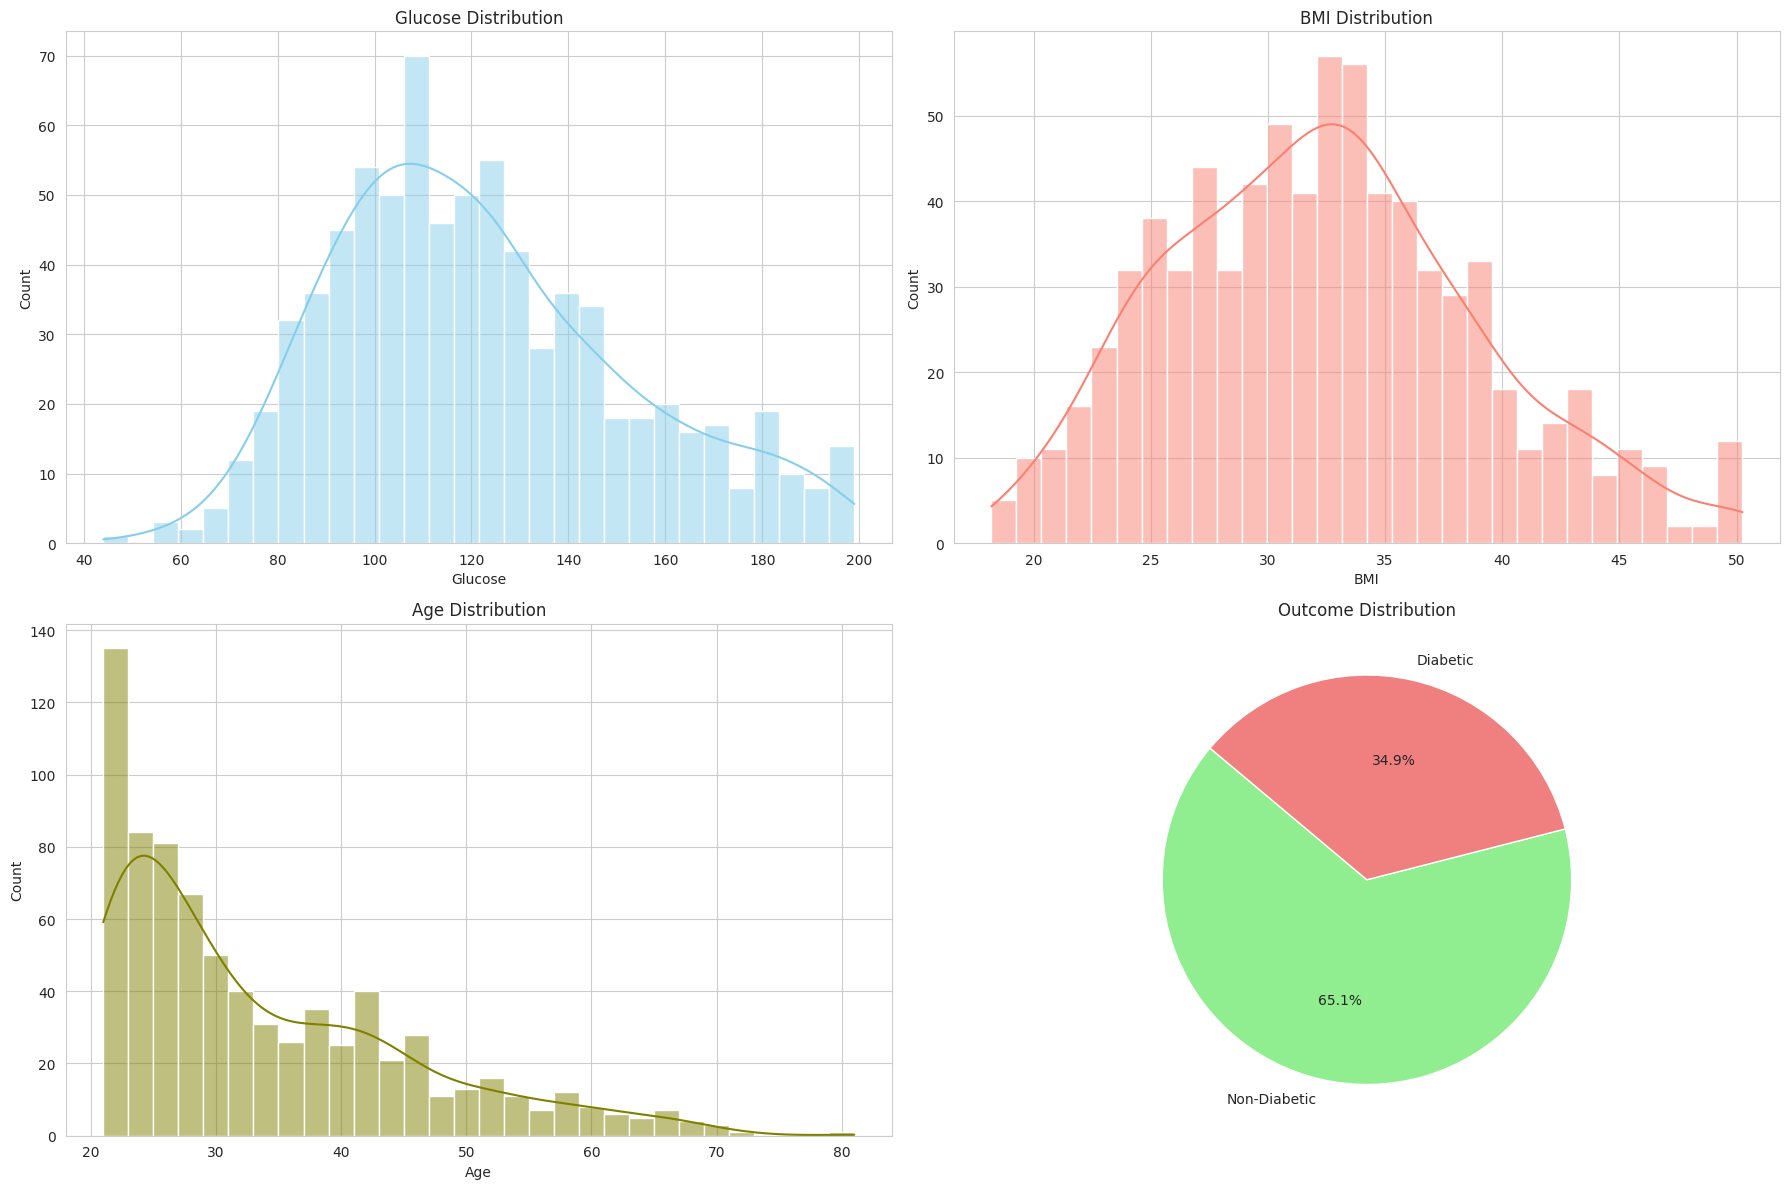

In [12]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the figure
plt.figure(figsize=(18, 12))

# Histogram of Glucose
plt.subplot(2, 2, 1)
sns.histplot(df["Glucose"], kde=True, color="skyblue", bins=30)
plt.title("Glucose Distribution")

# Histogram of BMI
plt.subplot(2, 2, 2)
sns.histplot(df["BMI"], kde=True, color="salmon", bins=30)
plt.title("BMI Distribution")

# Histogram of Age
plt.subplot(2, 2, 3)
sns.histplot(df["Age"], kde=True, color="olive", bins=30)
plt.title("Age Distribution")

# Pie chart for Outcome
plt.subplot(2, 2, 4)
df["Outcome"].value_counts().plot.pie(
    autopct="%1.1f%%",
    colors=["lightgreen", "lightcoral"],
    labels=["Non-Diabetic", "Diabetic"],
    startangle=140,
)
plt.ylabel("")
plt.title("Outcome Distribution")

plt.tight_layout()
plt.show()

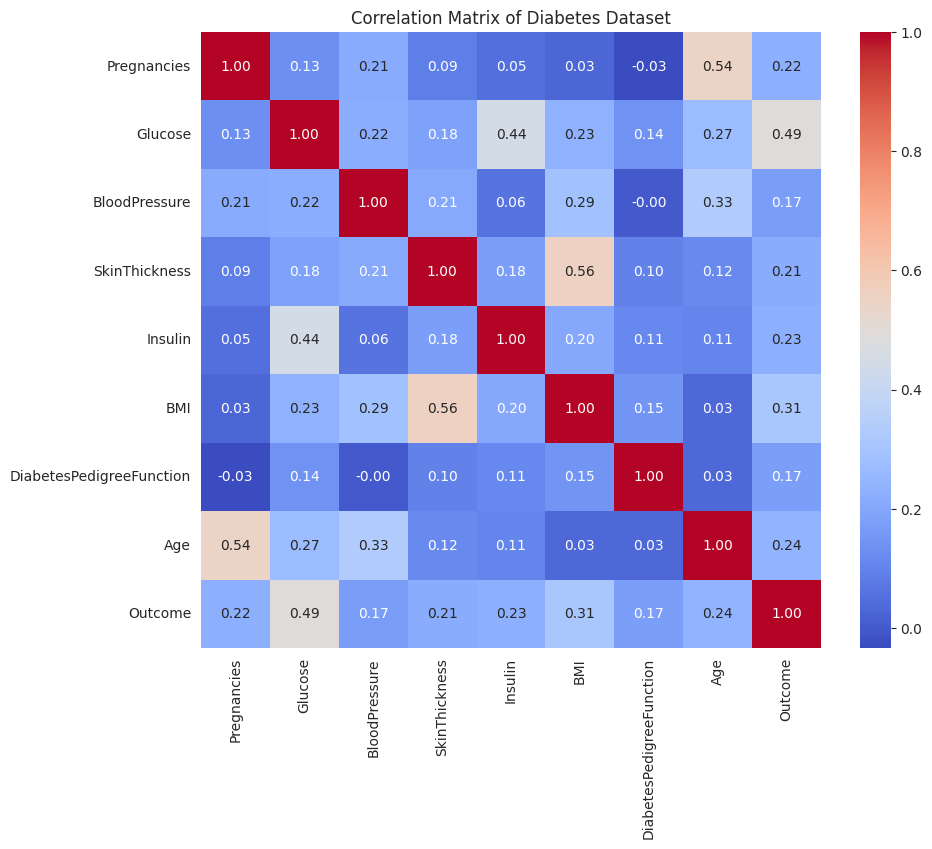

In [13]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Diabetes Dataset")
plt.show()

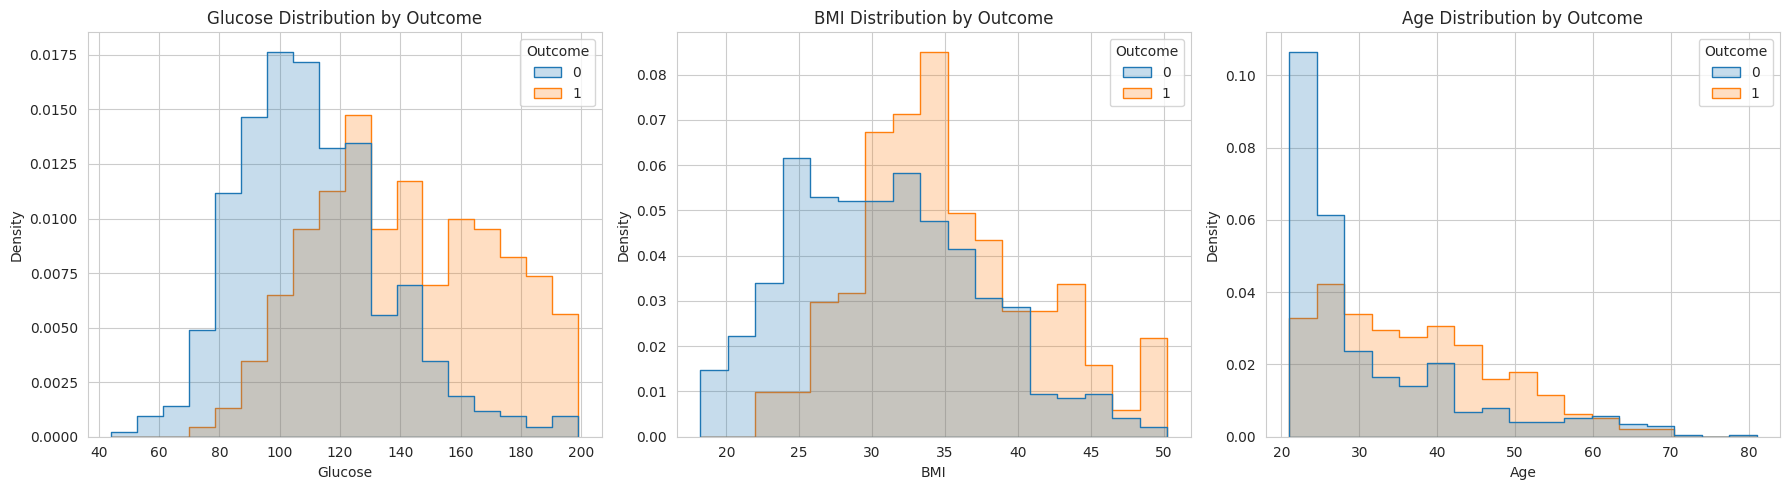

In [14]:
# Initialize the figure for comparative analysis
plt.figure(figsize=(18, 5))

# List of variables for comparative analysis
variables = ["Glucose", "BMI", "Age"]

for i, variable in enumerate(variables, 1):
    plt.subplot(1, 3, i)
    sns.histplot(
        data=df,
        x=variable,
        hue="Outcome",
        element="step",
        stat="density",
        common_norm=False,
    )
    plt.title(f"{variable} Distribution by Outcome")

plt.tight_layout()
plt.show()

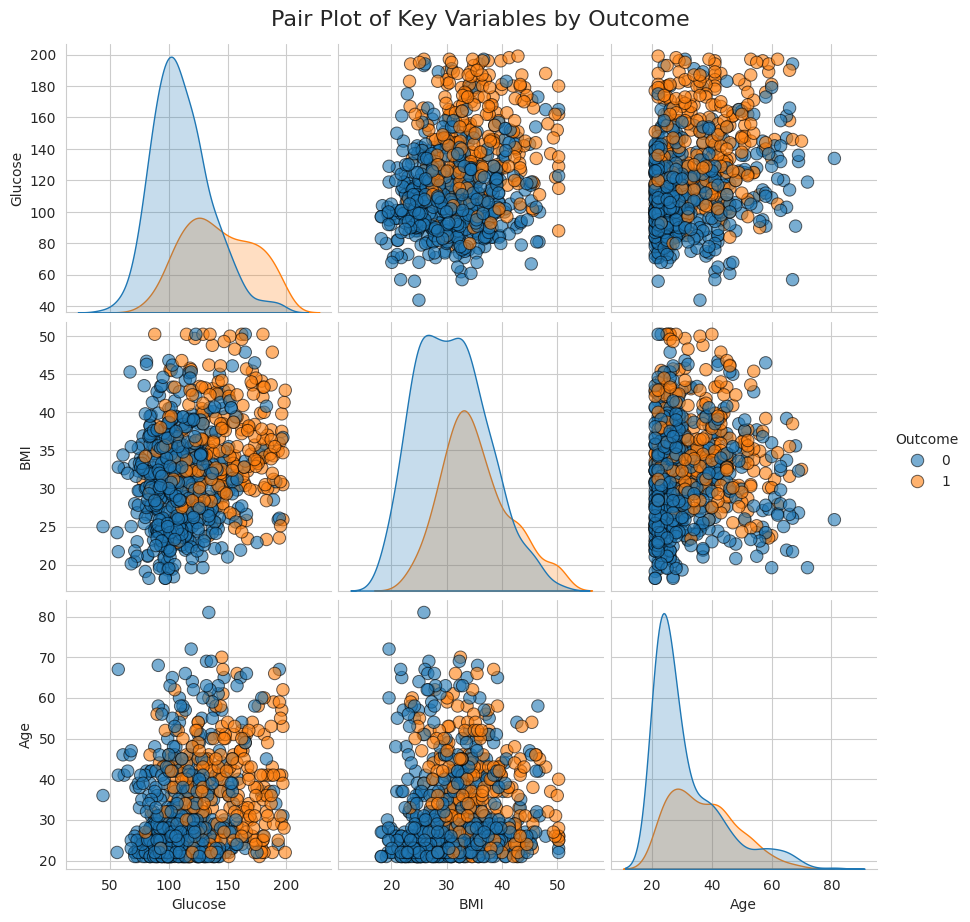

In [15]:
# Select a subset of the dataset for the pair plot
subset_df = df[["Glucose", "BMI", "Age", "Outcome"]]

# Create a pair plot
sns.pairplot(
    subset_df,
    hue="Outcome",
    diag_kind="kde",
    plot_kws={"alpha": 0.6, "s": 80, "edgecolor": "k"},
    height=3,
)
plt.suptitle("Pair Plot of Key Variables by Outcome", size=16, y=1.02)
plt.show()

In [16]:
def plot_distribution(df_select, size_bin):  
    # 2 datasets
    tmp1 = df[df_select]
    tmp2 = H[df_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['diabetic', 'healthy']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = df_select)

    py.iplot(fig, filename = 'Density plot')

In [17]:
# Columns to impute
columns_to_impute = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Impute zeros with the median of the respective column
for column in columns_to_impute:
    median_value = df[df[column] != 0][column].median()
    df[column] = df[column].replace(0, median_value)

# Show a summary to verify changes
df[columns_to_impute].describe()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
count,768.000000,768.000000,768.000000,768.000000,768.000000
mean,121.656250,72.358073,29.041667,136.029948,32.393359
std,30.438286,11.697097,8.438802,65.560632,6.667471
min,44.000000,40.000000,7.000000,14.000000,18.200000
25%,99.750000,64.000000,25.000000,121.500000,27.500000
50%,117.000000,72.000000,29.000000,125.000000,32.300000
75%,140.250000,80.000000,32.000000,127.250000,36.600000
max,199.000000,104.000000,57.000000,360.625000,50.250000


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Columns that should not have a zero value, but do
columns_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace zeros with NaN and then impute with mean
df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)
df.fillna(df.mean(), inplace=True)

# Splitting the dataset into features (X) and target variable (y)
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Confirm the imputation and scaling
X_train_scaled[:5], y_train[:5]

(array([[-0.8362943 , -0.89454593, -1.0401199 , -1.27678076, -1.21088362,
         -1.23344154, -0.61421636, -0.94861028],
        [ 0.39072767, -0.56247683, -0.02041312,  0.0319029 ,  2.94714299,
          0.69516629, -0.90973787, -0.43466673],
        [-1.14304979,  0.43373048, -0.36031538,  1.57852905,  1.77915798,
          1.49628031, -0.30699103, -0.77729576],
        [ 0.08397217,  0.30090284, -0.36031538, -0.91986704,  0.47101478,
          0.13141939, -0.90681191, -0.43466673],
        [-0.8362943 , -0.62889065, -2.73963119,  1.10264408, -0.82155528,
          1.64463476, -0.83951493, -0.00638043]]),
 334    0
 139    0
 485    1
 547    0
 18     0
 Name: Outcome, dtype: int64)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred = log_reg.predict(X_test_scaled)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])

accuracy, precision, recall, f1, roc_auc

(0.7402597402597403,
 0.6351351351351351,
 0.5875,
 0.6103896103896104,
 0.7986754966887417)

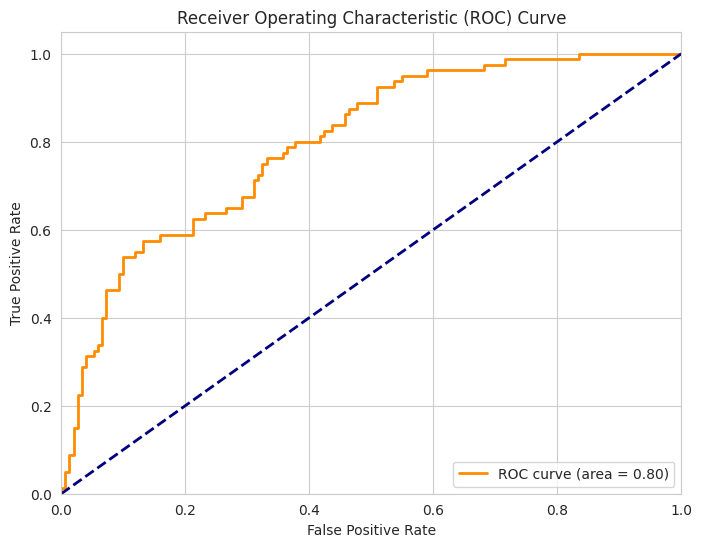

In [20]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [21]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering

k_values = range(2, 10)  # Let's consider 2 to 9 clusters
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    labels = kmeans.predict(X_train)
    silhouette_scores.append(silhouette_score(X_train, labels))

# Determine the k with the highest silhouette score
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
optimal_silhouette_score = max(silhouette_scores)

optimal_k, optimal_silhouette_score, silhouette_scores

(2,
 0.6479733781367976,
 [0.6479733781367976,
  0.2980494157837694,
  0.33663555173330717,
  0.35366228957076756,
  0.2779420735087604,
  0.24867927781465254,
  0.2403954953245586,
  0.23719911651247005])

-----------------------------------------------------------------------------------------------------------------------------------

# testing with differnt models to see which one is the best

In [22]:
# Ensure 'df' is a DataFrame object
df = pd.DataFrame(df)

# Now you can use 'iloc'
label= df.iloc[:,-1]
label


0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

In [23]:
# Ensure 'df' is a DataFrame object
df = pd.DataFrame(df)

# Now you can use 'iloc'
data_health= df.iloc[:,:-1]
data_health

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63
764,2,122.0,70.0,27.0,125.0,36.8,0.340,27
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30
766,1,126.0,60.0,29.0,125.0,30.1,0.349,47


In [24]:
ss = StandardScaler()
data_health = ss.fit_transform(data_health)
data_health = pd.DataFrame(data_health)  
data_health.head()

,0,1,2,3,4,5,6,7
0,0.639947,0.866045,-0.030632,0.706524,-0.168350,0.181092,0.468492,1.425995
1,-0.844885,-1.205066,-0.543914,-0.004941,-0.168350,-0.869465,-0.365061,-0.190672
2,1.233880,2.016662,-0.715008,-0.004941,-0.168350,-1.364728,0.604397,-0.105584
3,-0.844885,-1.073567,-0.543914,-0.716405,-0.641503,-0.644346,-0.920763,-1.041549
4,-1.141852,0.504422,-2.768136,0.706524,0.487959,1.606849,5.484909,-0.020496


In [25]:
# testing with differnt models to see which one is the best

df= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



In [26]:
#first model is logistic regression
log_reg = LogisticRegression(solver='liblinear', random_state=42)

In [27]:
log_reg_accuracy = []

In [28]:

for train_idx, test_idx in df.split(data_health,label):
    X_train, X_test= data_health.iloc[train_idx,:], data_health.iloc[test_idx,:]
    y_train, y_test= label[train_idx], label[test_idx]

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression
log_reg = LogisticRegression()

# Perform cross-validation
log_reg_accuracy = cross_val_score(log_reg, X, y, cv=5)

print('Logistic Regression - Accuracy of each fold:', *log_reg_accuracy)
print('Average accuracy of Logistic Regression: ', np.mean(log_reg_accuracy))
print('Standard deviation of accuracy:', np.std(log_reg_accuracy))
print('='*50)

Logistic Regression - Accuracy of each fold: 0.7467532467532467 0.7597402597402597 0.7727272727272727 0.8169934640522876 0.7581699346405228
Average accuracy of Logistic Regression:  0.7708768355827178
Standard deviation of accuracy: 0.024485112742600304


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [30]:
#second model is decision tree
df = StratifiedKFold(n_splits=8, shuffle=True, random_state=None)

In [31]:
dt = DecisionTreeClassifier()


In [32]:
dt_accuracy= []

In [33]:
for train_idx, test_idx in df.split(data_health,label):
    X_train, X_test= data_health.iloc[train_idx,:], data_health.iloc[test_idx,:]
    y_train, y_test= label[train_idx], label[test_idx]

In [34]:
from sklearn.model_selection import cross_val_score

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier()

# Perform cross-validation
dt_accuracy = cross_val_score(dt, X, y, cv=5)

print('Decision Tree- Accuracy of each fold:',*dt_accuracy) 
print('Average accuracy of Decision Tree: ', np.mean(dt_accuracy))
print('Standard deviation of accuracy:', np.std(dt_accuracy))
print('='*50)

Decision Tree- Accuracy of each fold: 0.7207792207792207 0.6558441558441559 0.6883116883116883 0.7647058823529411 0.7581699346405228
Average accuracy of Decision Tree:  0.7175621763857059
Standard deviation of accuracy: 0.04134385934953839


In [35]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(data_health, label, test_size=0.2, random_state=42)

In [36]:

log_reg = LogisticRegression(solver='liblinear')
param_grid= {"C": np.logspace(-5,5,22), "penalty": ["l1","l2"]}
log_reg_grid = GridSearchCV(log_reg, param_grid= param_grid, cv= 25, verbose= True, n_jobs= -1)
log_reg_grid.fit(X_train, y_train)


Fitting 25 folds for each of 44 candidates, totalling 1100 fits


GridSearchCV(cv=25, estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': array([1.00000000e-05, 2.99357729e-05, 8.96150502e-05, 2.68269580e-04,
       8.03085722e-04, 2.40409918e-03, 7.19685673e-03, 2.15443469e-02,
       6.44946677e-02, 1.93069773e-01, 5.77969288e-01, 1.73019574e+00,
       5.17947468e+00, 1.55051578e+01, 4.64158883e+01, 1.38949549e+02,
       4.15956216e+02, 1.24519708e+03, 3.72759372e+03, 1.11588399e+04,
       3.34048498e+04, 1.00000000e+05]),
                         'penalty': ['l1', 'l2']},
             verbose=True)

In [37]:
print(log_reg_grid.best_score_)
print(log_reg_grid.best_params_)

0.777037037037037
{'C': 0.5779692884153314, 'penalty': 'l1'}


In [39]:
#Testing on test data
log_reg = LogisticRegression(C=0.5779692884153314, penalty= 'l2', solver= 'liblinear')

In [40]:
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.75

In [41]:
y_pred = log_reg.predict(X_test)

In [43]:
#confusion matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("True Negatives: ", tn)
print("False Positives: ", fp)
print("False Negatives: ", fn)
print("True Positives: ", tp)






True Negatives:  55
False Positives:  8
False Negatives:  16
True Positives:  17


In [44]:
#classification report 

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82        63
           1       0.68      0.52      0.59        33

    accuracy                           0.75        96
   macro avg       0.73      0.69      0.70        96
weighted avg       0.74      0.75      0.74        96



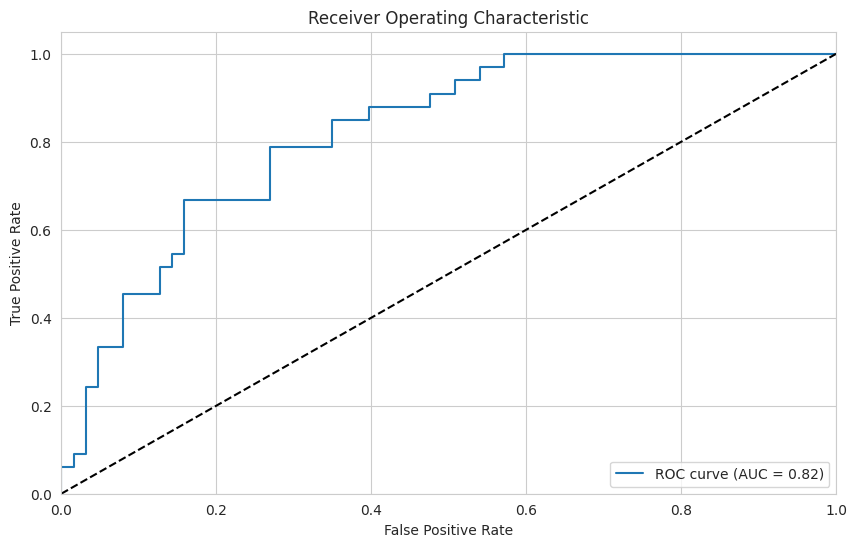

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
